In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf

symbol = "SPY"
data = yf.download(symbol, start="2020-03-15", end="2020-07-15", interval="1d")
data.columns = data.columns.droplevel(0)
data.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
data.reset_index(inplace=True)
data['DateNum'] = mdates.date2num(data['Date'])
df = data[['DateNum','Open','High','Low','Close']]

[*********************100%***********************]  1 of 1 completed


In [30]:
def detect_support_point(df, idx):
    if idx < 2 or idx > df.shape[0] - 3:
        return False
    segment_lows = [df['Low'][idx-2], df['Low'][idx-1], df['Low'][idx], df['Low'][idx+1], df['Low'][idx+2]]
    return df['Low'][idx] == min(segment_lows)

def detect_resistance_point(df, idx):
    if idx < 2 or idx > df.shape[0] - 3:
        return False
    segment_highs = [df['High'][idx-2], df['High'][idx-1], df['High'][idx], df['High'][idx+1], df['High'][idx+2]]
    return df['High'][idx] == max(segment_highs)

In [31]:
raw_levels = []
for i in range(len(df)):
    if detect_support_point(df, i):
        raw_levels.append({
            'index': i,
            'price': df['Low'][i],
            'date': df['DateNum'][i],
            'type': 'support'
        })
    elif detect_resistance_point(df, i):
        raw_levels.append({
            'index': i,
            'price': df['High'][i],
            'date': df['DateNum'][i],
            'type': 'resistance'
        })

In [32]:
avg_candle_height = np.mean(df['High'] - df['Low'])

def sufficiently_far(new_level_price, accepted_prices, threshold):
    return all(abs(new_level_price - ap) > threshold for ap in accepted_prices)

final_levels = []
unique_prices = []

for lvl in raw_levels:
    if sufficiently_far(lvl['price'], unique_prices, avg_candle_height):
        final_levels.append(lvl)
        unique_prices.append(lvl['price'])

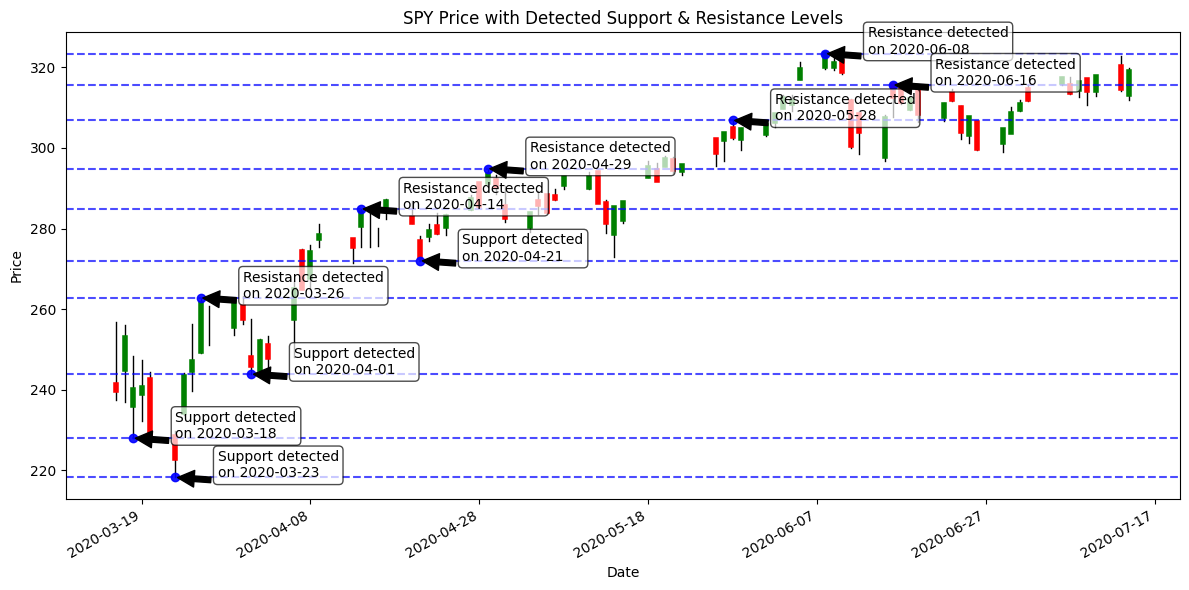

In [33]:
fig, ax = plt.subplots(figsize=(12,6))

# Plot each candle
for idx, row in df.iterrows():
    color = 'green' if row['Close'] >= row['Open'] else 'red'
    # Candle wick
    ax.plot([row['DateNum'], row['DateNum']], [row['Low'], row['High']], color='black', linewidth=1)
    # Candle body
    ax.plot([row['DateNum'], row['DateNum']], [row['Open'], row['Close']], color=color, linewidth=4)

# Draw key levels
for lvl in final_levels:
    ax.axhline(y=lvl['price'], xmin=0, xmax=1, color='blue', linestyle='--', alpha=0.7)
    # Mark the origin candle on the chart
    ax.plot(lvl['date'], lvl['price'], 'o', color='blue', markersize=6, alpha=0.9)
    # Annotate to clarify what happened here
    level_type = "Support" if lvl['type'] == 'support' else "Resistance"
    ax.annotate(
        f"{level_type} detected\non {mdates.num2date(lvl['date']).strftime('%Y-%m-%d')}",
        xy=(lvl['date'], lvl['price']),
        xytext=(lvl['date']+5, lvl['price']),
        arrowprops=dict(facecolor='black', shrink=0.05),
        fontsize=10,
        bbox=dict(boxstyle="round", fc="w", ec="black", alpha=0.7)
    )

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()
ax.set_title(f"{symbol} Price with Detected Support & Resistance Levels")
ax.set_xlabel("Date")
ax.set_ylabel("Price")
plt.tight_layout()
plt.show()